In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter
from ast import literal_eval
import matplotlib.colors as mcolor
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import seaborn as sns

# File paths for the Kaggle dataset
edge_file = "C:\\Users\\margh\\OneDrive\\Documenti\\unibo\\complex network\\edges.csv\\edges.csv"
node_file = "C:\\Users\\margh\\OneDrive\\Documenti\\unibo\\complex network\\nodes.csv\\nodes.csv"

# === 2. LOAD DATA === #

edges_df = pd.read_csv(edge_file)
nodes_df = pd.read_csv(node_file)

print("Nodes:")
print(nodes_df.head())

print("\nEdges:")
print(edges_df.head())

G = nx.Graph()
# parse genres strings to objects or set as empty list if not a string:
nodes_df['genres'] = nodes_df['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else [])

    
# Add nodes with attributes
for _, row in nodes_df.iterrows():
    node_id = row['spotify_id']
    G.add_node(node_id,
                name=row['name'],
                followers=row['followers'],
                popularity=row['popularity'],
                genres=row['genres'],
                chart_hits=row['chart_hits'])

    # Add edges with weight
for _, row in edges_df.iterrows():
    # If the CSV has a 'weight' column:
    # G.add_edge(row['id_0'], row['id_1'], weight=row.get('weight', 1))
    G.add_edge(row['id_0'], row['id_1'])

Nodes:
               spotify_id                name  followers  popularity  \
0  48WvrUGoijadXXCsGocwM4           Byklubben     1738.0          24   
1  4lDiJcOJ2GLCK6p9q5BgfK            Kontra K  1999676.0          72   
2  652XIvIBNGg3C0KIGEJWit               Maxim    34596.0          36   
3  3dXC1YPbnQPsfHPVkm1ipj  Christopher Martin   249233.0          52   
4  74terC9ol9zMo8rfzhSOiG       Jakob Hellman    21193.0          39   

                                              genres  \
0                     ['nordic house', 'russelater']   
1             ['christlicher rap', 'german hip hop']   
2                                                 []   
3  ['dancehall', 'lovers rock', 'modern reggae', ...   
4  ['classic swedish pop', 'norrbotten indie', 's...   

                                          chart_hits  
0                                         ['no (3)']  
1  ['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...  
2                                         ['de (1)']  
3  


--- Graph Structure ---
Number of nodes: 156326
Number of edges: 300386
Density: 0.0000
Connected components: 4338
Average clustering coefficient: 0.0808
Degree assortativity coefficient: -0.0768


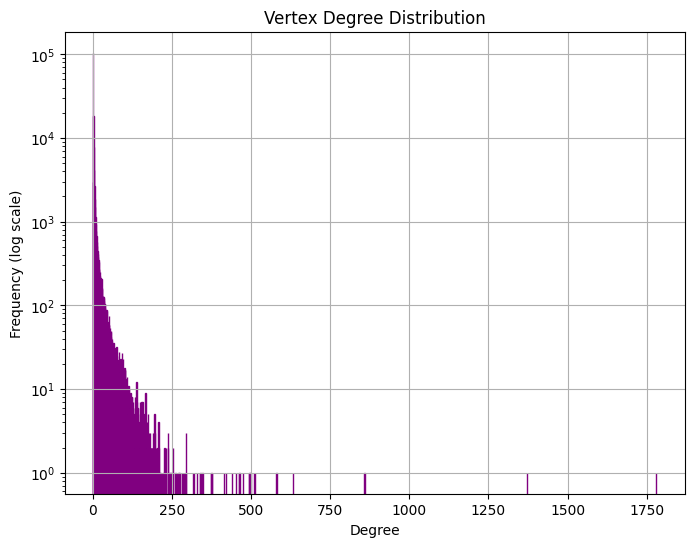

In [3]:
#analysis on the entire graph, although it has the bias of not including connections between non-seed artists:
#Let's check the vertex degree distribution (number of feature collaborations per artist):

print("\n--- Graph Structure ---")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Density: {nx.density(G):.4f}")
print(f"Connected components: {nx.number_connected_components(G)}")

clustering = nx.clustering(G)
avg_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {avg_clustering:.4f}")

assortativity = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity coefficient: {assortativity:.4f}")


degrees = [degree for node, degree in G.degree()]
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1), edgecolor='purple')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency (log scale)')
plt.title('Vertex Degree Distribution')
plt.grid(True)
plt.show()



In [4]:
# funcs for power law analysis:

# define linear model for log-log data:
def linear_model(log_x, a, b):
    return a + b * log_x

# plot & fit log-log data:
def plot_and_fit_log_log(graph):
    degrees = [deg for _, deg in graph.degree()]
    degree_count = Counter(degrees)
    x = np.array(list(degree_count.keys()))
    y = np.array(list(degree_count.values()))

    # remove zeros & ensure consistent filtering:
    positive_indices = (x > 0) & (y > 0)
    x, y = x[positive_indices], y[positive_indices]
    
    # log-transform data:
    log_x = np.log(x)
    log_y = np.log(y)
    
    # scatter plot of log-log data:
    plt.scatter(log_x, log_y, label="Log-Log Data", alpha=0.7, color='darkviolet')
    plt.title("Log-Log Degree Distribution")
    plt.xlabel("Log(Degree)")
    plt.ylabel("Log(Count)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # fit straight line to log-log data:
    params, _ = curve_fit(linear_model, log_x, log_y)
    intercept, slope = params

    power_law_text = f"$P(k) \\ sim k^{{{slope:.4f}}}$"
    plt.text(log_x.min() + 3, log_y.max() - 2, power_law_text, fontsize=12, color="black")

    r2_text = f"$R^2$ = {compute_r2(graph):.4f}"
    plt.text(log_x.min() + 1, log_y.max() - 7, r2_text, fontsize=12, color="black")

    # plot data w/ fitted line:
    plt.scatter(log_x, log_y, label="Log-Log Data", alpha=0.7, color='darkviolet')
    plt.plot(log_x, linear_model(log_x, *params), color="darkorange", label=f"Fit: slope = {slope:.4f}")
    plt.title("Log-Log Degree Distribution with Fitted Line")
    plt.xlabel("Log(Degree)")
    plt.ylabel("Log(Count)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return slope

# computes R^2 for the fit:
def compute_r2(graph):
    degrees = [deg for _, deg in graph.degree()]
    degree_count = Counter(degrees)
    x = np.array(list(degree_count.keys()))
    y = np.array(list(degree_count.values()))
    
    # remove zeros:
    positive_indices = (x > 0) & (y > 0)
    x, y = x[positive_indices], y[positive_indices]
    
    log_x = np.log(x)
    log_y = np.log(y)
    
    # fit straight line:
    params, _ = curve_fit(linear_model, log_x, log_y)
    predicted_log_y = linear_model(log_x, *params)
    
    # calculate R^2:
    r2 = r2_score(log_y, predicted_log_y)
    print(f"R^2: {r2:.4f}")
    return r2

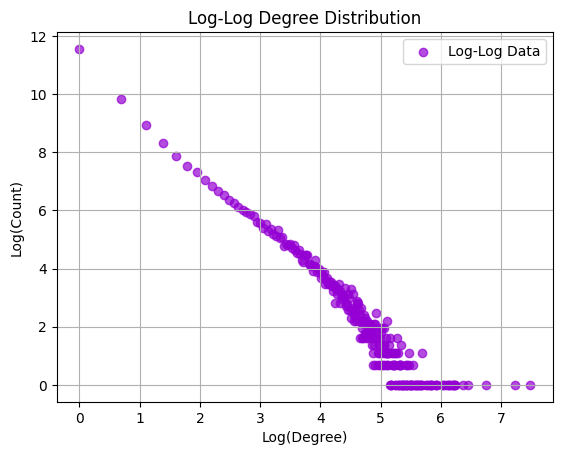

R^2: 0.9331


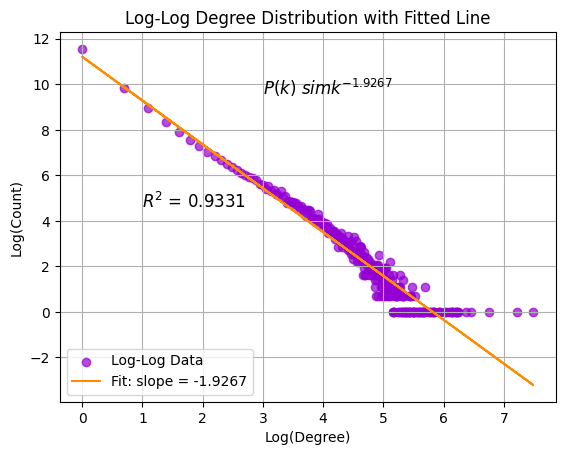

R^2: 0.9331
Slope of the log-log fit: -1.9267
R^2 value: 0.9331


In [5]:
# power law analysis:

slope = plot_and_fit_log_log(G)
r2_value = compute_r2(G)

print(f"Slope of the log-log fit: {slope:.4f}")
print(f"R^2 value: {r2_value:.4f}")

From the above plot, we can see that the largest connected component of the entire graph follows a power law strongly (R^2 = 0.93), with slope -1.93.

Exploratory Data Analysis Popularity captures what users are listening to

In [6]:
def filter_graph_by_popularity(G, threshold):
    filtered_nodes = [n for n, data in G.nodes(data=True) if data.get('popularity', 0) > threshold]
    return G.subgraph(filtered_nodes)

def analyze_centralities(G):
    print("\n--- Centrality Measures (Largest Connected Component) ---")

    # Extract largest connected component
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        Gc = G.subgraph(largest_cc).copy()
        print(f"Using largest connected component with {Gc.number_of_nodes()} nodes.")
    else:
        Gc = G

    degree_centrality = nx.degree_centrality(Gc)
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top 10 by Degree Centrality:")
    for artist, score in top_degree:
        print(f"{artist}: {score:.4f}")

    eigenvector_centrality = nx.eigenvector_centrality(Gc, max_iter=1000)
    top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 by Eigenvector Centrality:")
    for artist, score in top_eigenvector:
        print(f"{artist}: {score:.4f}")

    G_filtered = filter_graph_by_popularity(G, 50)
    print("\n--- Filtered Graph (Popularity > 50) Centrality ---")
    degree_centrality = nx.degree_centrality(G_filtered)
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top 10 by Degree Centrality G filtered:")
    for artist, score in top_degree:
        print(f"{artist}: {score:.4f}")


    G.remove_nodes_from(list(nx.isolates(G)))
    eigenvector_centrality = nx.eigenvector_centrality(G_filtered, max_iter=1000)
    top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 by Eigenvector Centrality: G filtered")
    for artist, score in top_eigenvector:
        print(f"{artist}: {score:.4f}")


    # verify node data:
    print("Sample node data:")
    list(G.nodes(data=True))[:5]

    return G

analyze_centralities(G)


--- Centrality Measures (Largest Connected Component) ---
Using largest connected component with 148386 nodes.
Top 10 by Degree Centrality:
5aIqB5nVVvmFsvSdExz408: 0.0120
1U5zgr455OGyIkLNXvDdrf: 0.0092
0f1IECbrVV952unZkzrsg2: 0.0058
4hV3aU0WKvFaiX5ugXP5hp: 0.0043
7jzR5qj8vFnSu5JHaXgFEr: 0.0039
0SfsnGyD8FpIN4U4WCkBZ5: 0.0035
13y7CgLHjMVRMDqxdx0Xdo: 0.0034
77AiFEVeAVj2ORpC85QVJs: 0.0034
7hJcb9fa4alzcOq3EaNPoG: 0.0033
5fMUXHkw8R8eOP2RNVYEZX: 0.0033

Top 10 by Eigenvector Centrality:
329e4yvIujISKGKz1BZZbO: 0.1247
6vXTefBL93Dj5IqAWq6OTv: 0.1175
13y7CgLHjMVRMDqxdx0Xdo: 0.1130
7c0XG5cIJTrrAgEC3ULPiq: 0.1090
55Aa2cqylxrFIXC767Z865: 0.1054
7bXgB6jMjp9ATFy66eO08Z: 0.1050
7hJcb9fa4alzcOq3EaNPoG: 0.1029
3EiLUeyEcA6fbRPSHkG5kb: 0.1007
1vyhD5VmyZ7KMfW5gqLgo5: 0.0988
1RyvyyTE3xzB2ZywiAwp0i: 0.0986

--- Filtered Graph (Popularity > 50) Centrality ---
Top 10 by Degree Centrality G filtered:
6cEuCEZu7PAE9ZSzLLc2oQ: 0.0220
7hJcb9fa4alzcOq3EaNPoG: 0.0208
1Cs0zKBU1kc0i8ypK3B9ai: 0.0194
77AiFEVeAVj2ORpC85

In the following we have

1.Complimentary Cumulative Distribution Function of the Popularity of all artists in the graph
2.Contribution of remaining artists to total popularity as low popularity nodes are removed

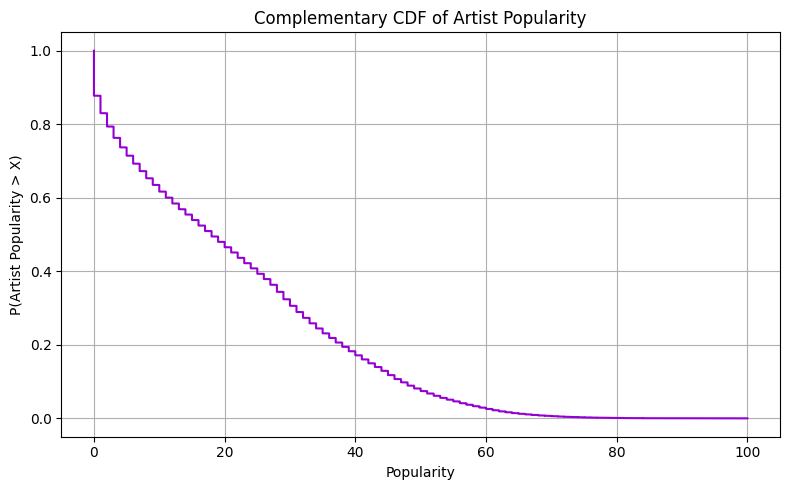

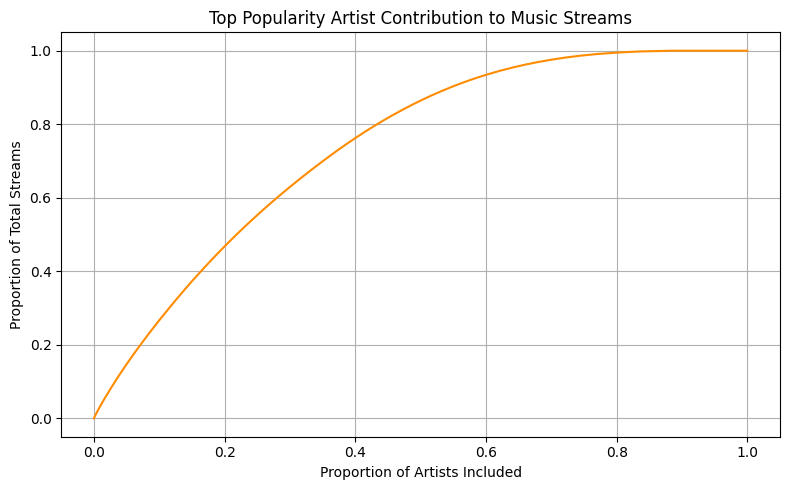

In [7]:
def plot_popularity_ccdf_and_contribution(G):
    # Extract valid popularity scores
    popularities = [d.get('popularity') for _, d in G.nodes(data=True) if d.get('popularity') is not None]
    popularities = np.array(sorted(popularities))

    # CCDF
    sorted_pop = np.sort(popularities)
    ccdf = 1. - np.arange(1, len(sorted_pop)+1) / len(sorted_pop)
    plt.figure(figsize=(8, 5))
    plt.plot(sorted_pop, ccdf, color='darkviolet')
    plt.xlabel("Popularity")
    plt.ylabel("P(Artist Popularity > X)")
    plt.title("Complementary CDF of Artist Popularity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # (b) Contribution of remaining artists to total popularity
    
    total_pop = np.sum(popularities)
    sorted_pop_desc = np.sort(popularities)[::-1]  # from highest to lowest
    cum_pop = np.cumsum(sorted_pop_desc) 
    fraction_total_pop = cum_pop / total_pop
    fraction_artists = np.arange(1, len(popularities)+1) / len(popularities)

    plt.figure(figsize=(8, 5))
    plt.plot(fraction_artists, fraction_total_pop, color='darkorange')
    plt.xlabel("Proportion of Artists Included")
    plt.ylabel("Proportion of Total Streams")
    plt.title("Top Popularity Artist Contribution to Music Streams")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_popularity_ccdf_and_contribution(G)

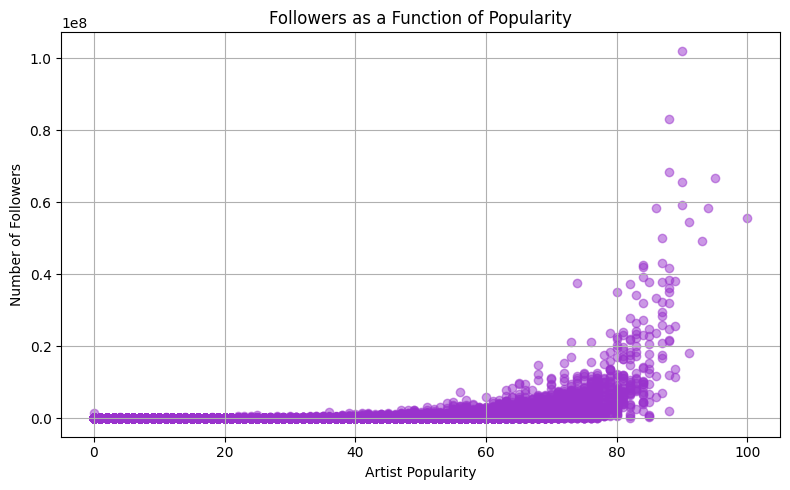

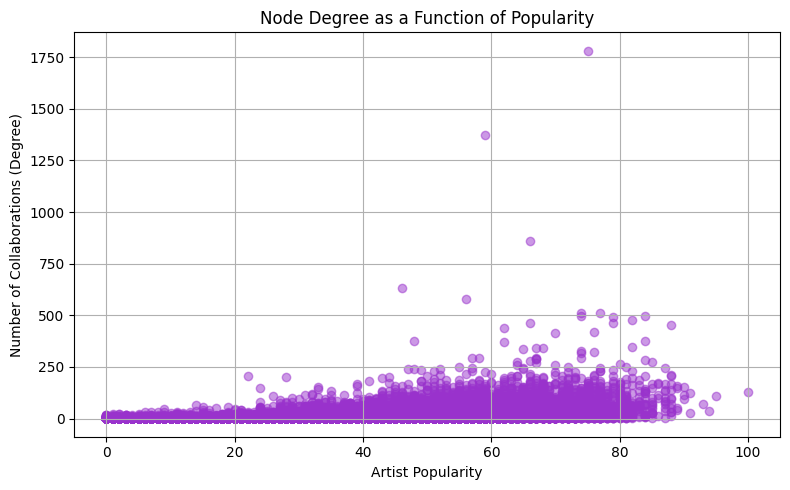

In [8]:
def plot_followers_and_degree_vs_popularity(G):
    data = [(d.get('popularity'), d.get('followers'), G.degree(n))
            for n, d in G.nodes(data=True)
            if d.get('popularity') is not None and d.get('followers') is not None]
    popularity, followers, degree = zip(*data)

    # Followers vs Popularity
    plt.figure(figsize=(8, 5))
    plt.scatter(popularity, followers, alpha=0.5, color='darkorchid')
    plt.xlabel("Artist Popularity")
    plt.ylabel("Number of Followers")
    plt.title("Followers as a Function of Popularity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Degree vs Popularity
    plt.figure(figsize=(8, 5))
    plt.scatter(popularity, degree, alpha=0.5, color='darkorchid')
    plt.xlabel("Artist Popularity")
    plt.ylabel("Number of Collaborations (Degree)")
    plt.title("Node Degree as a Function of Popularity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_followers_and_degree_vs_popularity(G)

In [9]:
#Friendship paradox analysis:
#compute the average degree of artists (nodes) and their collaborators:

degrees = dict(G.degree())
mean_degree = np.mean(list(degrees.values()))

#compute the average degree of collaborators (neighbors) for each node:
mean_neighbor_degrees = []
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    if neighbors:
        neighbor_degrees = [degrees[neighbor] for neighbor in neighbors]
        mean_neighbor_degrees.append(np.mean(neighbor_degrees))

# global mean of neighbor degrees
mean_of_neighbor_degrees = np.mean(mean_neighbor_degrees)

print(f"Average artist degree: {mean_degree:.2f}")
print(f"Average degree of collaborators: {mean_of_neighbor_degrees:.2f}")

if mean_of_neighbor_degrees > mean_degree:
    print("Friendship paradox observed: collaborators have, on average, more collaborators than a random artist.")
else:
    print("Friendship paradox NOT observed.")

Average artist degree: 3.92
Average degree of collaborators: 100.18
Friendship paradox observed: collaborators have, on average, more collaborators than a random artist.


Friendship paradox analysis: On averaged, an artist has less collaborators than the average of collaborations of the artist's collaboration.

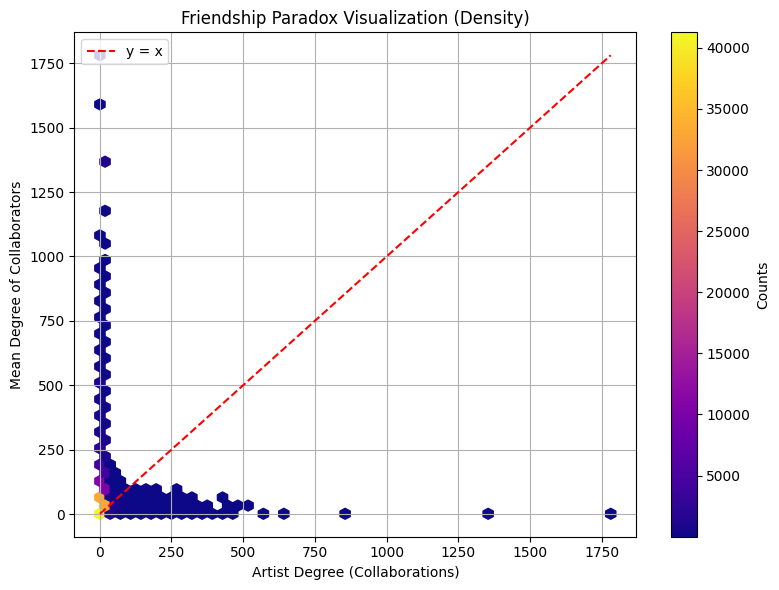

In [10]:
artist_degrees = []
mean_neighbor_degrees = []

for node in G.nodes():
    degree = G.degree(node)
    neighbors = list(G.neighbors(node))
    if neighbors:
        neighbor_degrees = [G.degree(neigh) for neigh in neighbors]
        mean_deg = np.mean(neighbor_degrees)
        artist_degrees.append(degree)
        mean_neighbor_degrees.append(mean_deg)

plt.figure(figsize=(8, 6))
plt.hexbin(artist_degrees, mean_neighbor_degrees, gridsize=50, cmap='plasma', mincnt=1)
plt.plot([min(artist_degrees), max(artist_degrees)],
         [min(artist_degrees), max(artist_degrees)],
         color='red', linestyle='--', label='y = x')
plt.xlabel("Artist Degree (Collaborations)")
plt.ylabel("Mean Degree of Collaborators")
plt.title("Friendship Paradox Visualization (Density)")
plt.colorbar(label='Counts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

we can visualize the friendship paradox with a scatter plot in which we have, for each artist, the number of collabboration on x axes and the average degree of his collaboration on y axis.

Interpretation: if the majority of the points is above the red line y=x, the friendship paradox is verified: the average of collaborators is bigger than the artist's degree.

In [11]:
##compute eigencentrality
# Compute eigenvector centrality for the whole network
try:
    eigencent = nx.eigenvector_centrality(G, max_iter=1000)
    # Print top 10 artists by eigenvector centrality
    top_10 = sorted(eigencent.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top 10 artists by eigenvector centrality:")
    for node, score in top_10:
        name = G.nodes[node].get('name', 'Unknown')
        genre = G.nodes[node].get('genres', [])
        print(f"{name}: {score:.4f}")
        print(f"{genre}")
except nx.PowerIterationFailedConvergence:
    print("Eigenvector centrality did not converge. Try increasing max_iter or check for disconnected components.")

Top 10 artists by eigenvector centrality:
Farruko: 0.1247
['latin hip hop', 'reggaeton', 'trap latino']
French Montana: 0.1175
['gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Gucci Mane: 0.1130
['atl hip hop', 'dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']
Ty Dolla $ign: 0.1090
['dance pop', 'hip hop', 'pop', 'pop rap', 'r&b', 'southern hip hop', 'trap', 'trap soul', 'urban contemporary']
Lil Wayne: 0.1054
['hip hop', 'new orleans rap', 'pop rap', 'rap', 'trap']
Chris Brown: 0.1050
['dance pop', 'pop', 'r&b']
Snoop Dogg: 0.1029
['g funk', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'west coast rap']
De La Ghetto: 0.1007
['latin hip hop', 'reggaeton', 'reggaeton flow', 'trap latino']
J Balvin: 0.0988
['reggaeton', 'reggaeton colombiano', 'trap latino']
Future: 0.0986
['atl hip hop', 'rap', 'southern hip hop', 'trap']


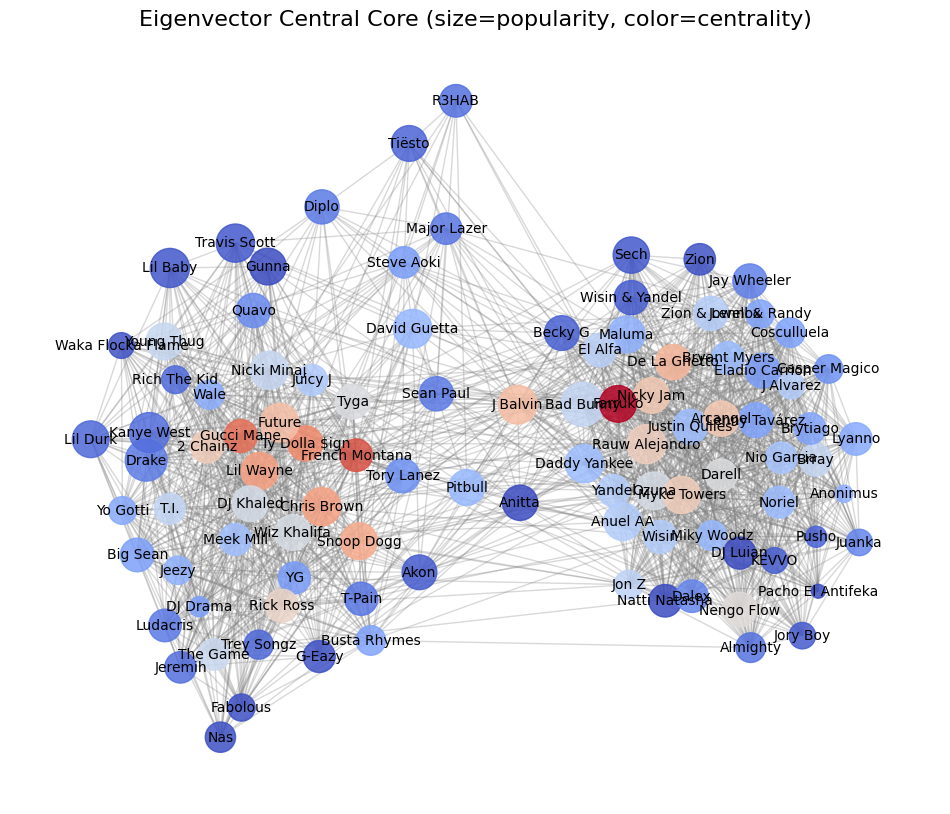

In [12]:
# Compute eigenvector centrality on the whole graph
eigencent = nx.eigenvector_centrality(G, max_iter=1000)

# Add centrality as node attribute
nx.set_node_attributes(G, eigencent, 'eigencentrality')

# Select top N nodes by eigenvector centrality 
N = 100
top_nodes = sorted(eigencent, key=eigencent.get, reverse=True)[:N]
core_subgraph = G.subgraph(top_nodes).copy()

# Get centrality and popularity for color and size
centrality = np.array([eigencent[n] for n in core_subgraph.nodes()])
popularity = np.array([G.nodes[n].get('popularity', 1) for n in core_subgraph.nodes()])

# Normalize centrality for colormap
centrality_norm = (centrality - centrality.min()) / (centrality.max() - centrality.min() + 1e-9)

# Map centrality to color (red=high, blue=low)
colors = plt.cm.coolwarm(centrality_norm)  

# Normalize popularity for node size
sizes = 100 + 900 * (popularity - popularity.min()) / (popularity.max() - popularity.min() + 1e-9)

# Layout
pos = nx.spring_layout(core_subgraph, seed=42)

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(core_subgraph, pos, node_color=colors, node_size=sizes, alpha=0.85)
nx.draw_networkx_edges(core_subgraph, pos, edge_color='gray', alpha=0.3)

# Draw artist names as labels
labels = {n: G.nodes[n].get('name', '') for n in core_subgraph.nodes()}
nx.draw_networkx_labels(core_subgraph, pos, labels, font_size=10, font_color='black')

plt.title("Eigenvector Central Core (size=popularity, color=centrality)", fontsize=16)
plt.axis('off')
plt.show()


In [13]:
popularity_thresholds = range(40, 100, 5)
most_central_artists = []

for threshold in popularity_thresholds:
    nodes_above = [n for n, d in G.nodes(data=True) if d.get('popularity', 0) >= threshold]
    subG = G.subgraph(nodes_above)

    if subG.number_of_nodes() == 0:
        most_central_artists.append((threshold, None, [], 0.0))
        continue

    if not nx.is_connected(subG):
        largest_cc = max(nx.connected_components(subG), key=len)
        subG = subG.subgraph(largest_cc)

    try:
        eigencent = nx.eigenvector_centrality(subG, max_iter=1000)
        if eigencent:
            max_node = max(eigencent, key=eigencent.get)
            max_value = eigencent[max_node]
            artist_name = G.nodes[max_node].get('name', max_node)
            artist_genre = G.nodes[max_node].get('genres', [])
            most_central_artists.append((threshold, artist_name, artist_genre, max_value))
        else:
            most_central_artists.append((threshold, None, [], 0.0))
    except nx.PowerIterationFailedConvergence:
        most_central_artists.append((threshold, None, [], 0.0))

# Stampa finale
for threshold, artist, genre, value in most_central_artists:
    print(f"Threshold {threshold}: Most central artist = {artist}, genre = {genre}, Eigenvector centrality = {value:.4f}")


Threshold 40: Most central artist = Farruko, genre = ['latin hip hop', 'reggaeton', 'trap latino'], Eigenvector centrality = 0.1246
Threshold 45: Most central artist = Farruko, genre = ['latin hip hop', 'reggaeton', 'trap latino'], Eigenvector centrality = 0.1237
Threshold 50: Most central artist = French Montana, genre = ['gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'], Eigenvector centrality = 0.1226
Threshold 55: Most central artist = French Montana, genre = ['gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'], Eigenvector centrality = 0.1327
Threshold 60: Most central artist = Ty Dolla $ign, genre = ['dance pop', 'hip hop', 'pop', 'pop rap', 'r&b', 'southern hip hop', 'trap', 'trap soul', 'urban contemporary'], Eigenvector centrality = 0.1419
Threshold 65: Most central artist = French Montana, genre = ['gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'], Eigenvector centrality = 0.1425
Threshold 70: Most central art

Pagerank algorithm: main idea: a web page is important if other important pages link it. A link coming from a page with a lot of link in output has less 'weight', while a link from an influential page has more weight.

We can use this algorithm to analyse our network

Top 10 artists by PageRank centrality:
Johann Sebastian Bach: 0.0037
Traditional: 0.0028
Jean Sibelius: 0.0011
Mc Gw: 0.0010
MC MN: 0.0008
הכוכב הבא: 0.0008
John Williams: 0.0007
A.R. Rahman: 0.0007
Armin van Buuren: 0.0007
Snoop Dogg: 0.0006


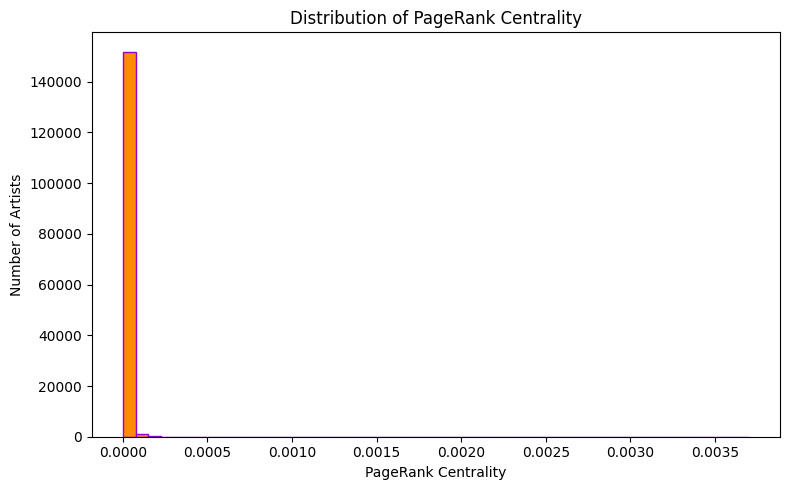

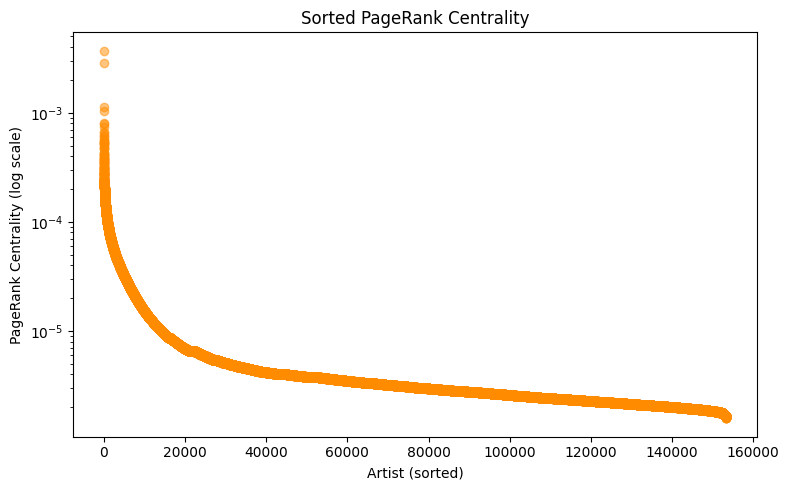

In [14]:
#Pagerank algorithm

pagerank = nx.pagerank(G, alpha=0.85)

# show the top 10 artists by Pagerank centrality
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 artists by PageRank centrality:")
for node, score in top_pagerank:
    name = G.nodes[node].get('name', 'Unknown')
    print(f"{name}: {score:.4f}")

# add pagerank as node attribute
nx.set_node_attributes(G, pagerank, 'pagerank')


plt.figure(figsize=(8,5))
plt.hist(list(pagerank.values()), bins=50, color='darkorange', edgecolor='darkviolet')
plt.xlabel("PageRank Centrality")
plt.ylabel("Number of Artists")
plt.title("Distribution of PageRank Centrality")
plt.tight_layout()
plt.show()

sorted_pr = sorted(pagerank.values(), reverse=True)
plt.figure(figsize=(8,5))
plt.plot(sorted_pr, marker='o', linestyle='none', alpha=0.5, color='darkorange')
plt.yscale('log')
plt.xlabel("Artist (sorted)")
plt.ylabel("PageRank Centrality (log scale)")
plt.title("Sorted PageRank Centrality")
plt.tight_layout()
plt.show()


now we analyze the relation between pagerank and artists degree. On the x axes we have the degree (number of collaboration of an artist, how many edges it has in the graph) On the y axes we have the pagerank, a measure of the "global importance" of the artist in the graph

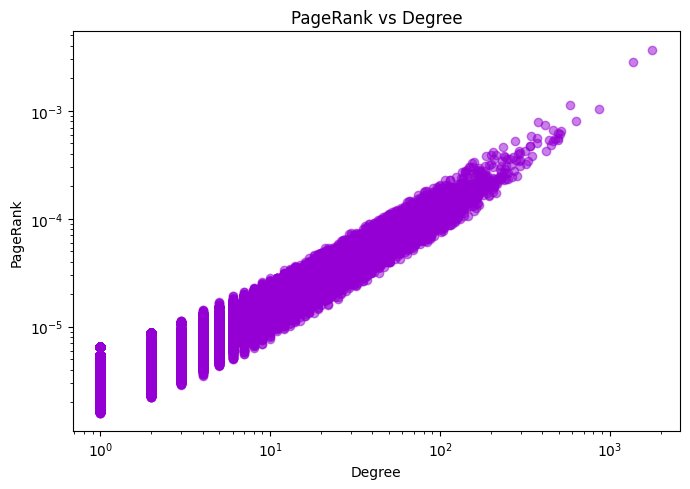

Pearson correlation: 0.9555
Spearman correlation: 0.7353


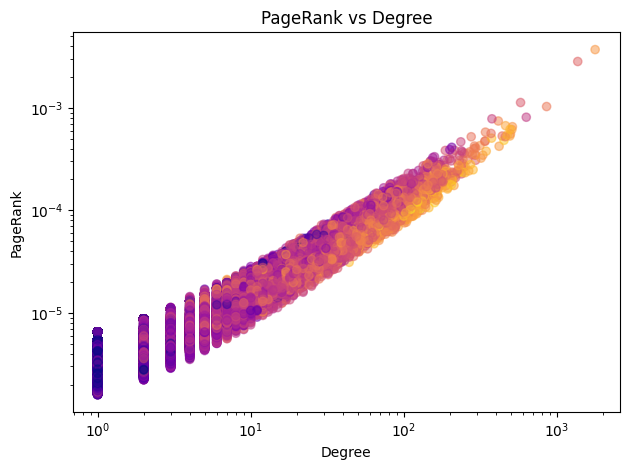

In [15]:
from scipy.stats import spearmanr, pearsonr
# Largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc).copy()

degree = dict(G.degree())
pagerank_values = np.array([pagerank[n] for n in G.nodes])
degree_values = np.array([degree[n] for n in G.nodes])

plt.figure(figsize=(7,5))
plt.scatter(degree_values, pagerank_values, alpha=0.5, color='darkviolet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("PageRank")
plt.title("PageRank vs Degree")
plt.tight_layout()
plt.show()


pearson_corr = pearsonr(degree_values, pagerank_values)
spearman_corr = spearmanr(degree_values, pagerank_values)

print(f"Pearson correlation: {pearson_corr[0]:.4f}")
print(f"Spearman correlation: {spearman_corr.correlation:.4f}")

popularities = np.array([G.nodes[n].get('popularity', 0) for n in G.nodes])
plt.scatter(degree_values, pagerank_values, c=popularities, cmap='plasma', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("PageRank")
plt.title("PageRank vs Degree")
plt.tight_layout()
plt.show()



we see that we have an increasing behaviour in log-log scale, meaning that there is a strong positive correlation between degree and PageRank: artists with more collaborations have a PageRak higher. limited dispersion: for each degree value, the PageRank does not vary much. Meaning that the number of collaborations is the main factor determining the pagerank. The graph shows the behaviour of a scale-free web: a lot of nodes have small connection (as we can see in the bottom left) and a few have a higher degree and high PageRank (top right)

Colored graph: in the second graph we have added a color according to popularity to see if some group dominate in some region of the graph.

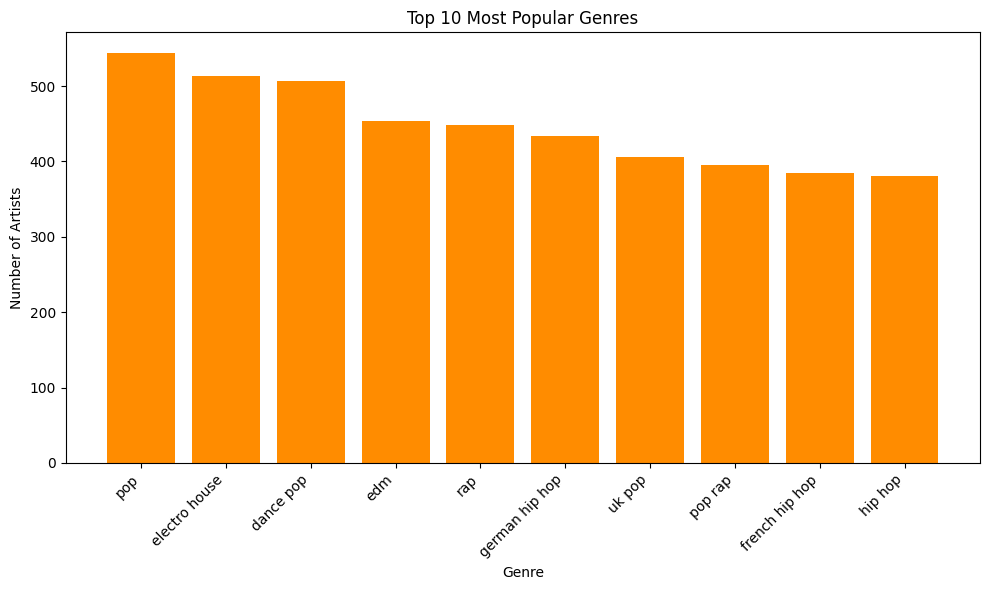

In [16]:
# Count all genre occurrences
all_genres = [genre for genres in nodes_df['genres'] for genre in genres]

genre_counts = Counter(all_genres)
top_n = 10
top_genres = [g for g, _ in genre_counts.most_common(top_n)]
# Get the 10 most common genres
top_10_genres = genre_counts.most_common(10)
genres, counts = zip(*top_10_genres)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='darkorange')
plt.xlabel("Genre")
plt.ylabel("Number of Artists")
plt.title("Top 10 Most Popular Genres")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
from collections import Counter

def estimate_genres_by_neighbors(G, node, top_n=5):
    if node not in G:
        print("Node not in G")
        return []

    neighbors = list(G.neighbors(node))
    print(f"{len(neighbors)} neighbors founded")

    neighbor_genres = []
    for neighbor in neighbors:
        genres = G.nodes[neighbor].get('genres', [])
        #print(f"Generi di {G.nodes[neighbor].get('name', neighbor)}: {genres}")
        neighbor_genres.extend(genres)

    if not neighbor_genres:
        print("No founded genre in neighbor")
        return []

    genre_counts = Counter(neighbor_genres)
    return genre_counts.most_common(top_n)

# ID Dua Lipa
target_node = '6M2wZ9GZgrQXHCFfjv46we'  

node_data = G.nodes[target_node]
print(node_data)

if target_node in G:
    print("Analysis for Dua Lipa:")
    result = estimate_genres_by_neighbors(G, target_node, top_n=10)
    print("Estimated Genres:")
    for genre, count in result:
        print(f"{genre}: {count}")
else:
    print("Node not founded in  graph.")


{'name': 'Dua Lipa', 'followers': 36163788.0, 'popularity': 88, 'genres': ['dance pop', 'pop', 'uk pop'], 'chart_hits': "['us (17)', 'gb (25)', 'ar (18)', 'au (20)', 'at (14)', 'be (23)', 'bo (10)', 'br (18)', 'bg (24)', 'ca (19)', 'cl (16)', 'co (18)', 'cr (18)', 'cy (21)', 'cz (17)', 'dk (17)', 'do (9)', 'ec (9)', 'eg (13)', 'sv (19)', 'ee (24)', 'fi (22)', 'fr (12)', 'de (14)', 'gr (22)', 'gt (12)', 'hn (18)', 'hk (19)', 'hu (24)', 'is (12)', 'in (6)', 'id (13)', 'ie (24)', 'il (12)', 'it (11)', 'jp (9)', 'lv (18)', 'lt (24)', 'lu (20)', 'my (16)', 'mt (20)', 'mx (18)', 'ma (6)', 'nl (20)', 'nz (19)', 'ni (18)', 'no (16)', 'pa (15)', 'py (9)', 'pe (16)', 'ph (18)', 'pl (23)', 'pt (21)', 'ro (18)', 'ru (6)', 'sa (10)', 'sg (21)', 'sk (23)', 'za (5)', 'kr (6)', 'es (18)', 'se (14)', 'ch (14)', 'tw (18)', 'th (11)', 'tr (12)', 'ua (6)', 'ae (15)', 'uy (15)', 'vn (19)']", 'eigencentrality': 0.022296246143411233, 'pagerank': 0.00013472222172577003}
Analysis for Dua Lipa:
136 neighbors fo

In [35]:
from collections import Counter

def estimate_genres_by_neighbors(G, node, top_n=5):
    """
    Estimate an artist's genres based on their neighbors' genres.
    Returns top_n most common genres weighted by frequency.
    """
    if node not in G:
        return []

    neighbor_genres = []
    for neighbor in G.neighbors(node):
        genres = G.nodes[neighbor].get('genres', [])
        neighbor_genres.extend(genres)

    if not neighbor_genres:
        return []

    genre_counts = Counter(neighbor_genres)
    return genre_counts.most_common(top_n)

# Cerca un nodo per nome (es. "Dua Lipa")
artist_name = "Dua Lipa"
target_node = None

for node in G.nodes():
    if G.nodes[node].get('name', '').lower() == artist_name.lower():
        target_node = node
        break

if target_node is not None:
    print(f"Artist: {artist_name}")
    print("Estimate neighbour:")
    estimated_genres = estimate_genres_by_neighbors(G, target_node, top_n=10)
    for genre, count in estimated_genres:
        print(f" - {genre}: {count}")
else:
    print(f"Artists '{artist_name}' not founded.")


Artist: Dua Lipa
Estimate neighbour:
 - edm: 29
 - electro house: 28
 - dance pop: 26
 - pop dance: 24
 - tropical house: 23
 - pop: 20
 - house: 18
 - pop edm: 9
 - uk dance: 8
 - rap: 8


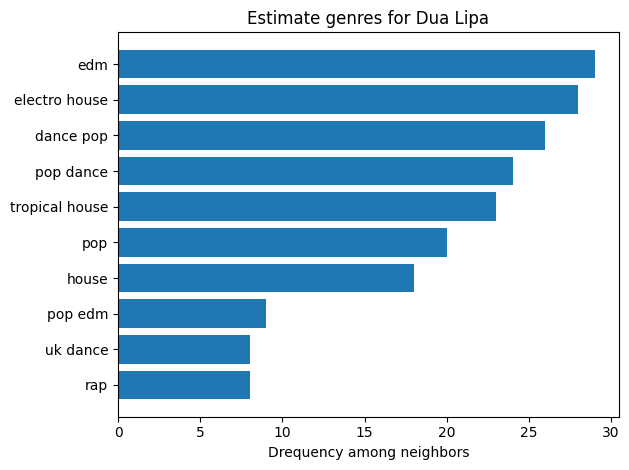

In [ ]:


genres, counts = zip(*estimated_genres)
plt.barh(genres[::-1], counts[::-1])  # from less to more frequent
plt.xlabel("Drequency among neighbors")
plt.title(f"Estimate genres for {artist_name}")
plt.tight_layout()
plt.show()


In [ ]:
#real genres of Dua Lipa
real_genres = G.nodes[target_node].get('genres', [])
real_genre_counts = Counter(real_genres)
print(real_genres)
# estimated genres from neighbors
estimated_genres = estimate_genres_by_neighbors(G, target_node, top_n=10)
estimated_genre_counts = dict(estimated_genres)


['dance pop', 'pop', 'uk pop']


In [37]:
all_genres = set(real_genre_counts.keys()).union(estimated_genre_counts.keys())

genres = sorted(all_genres)
x = np.arange(len(genres))

real_values = [real_genre_counts.get(g, 0) for g in genres]
estimated_values = [estimated_genre_counts.get(g, 0) for g in genres]


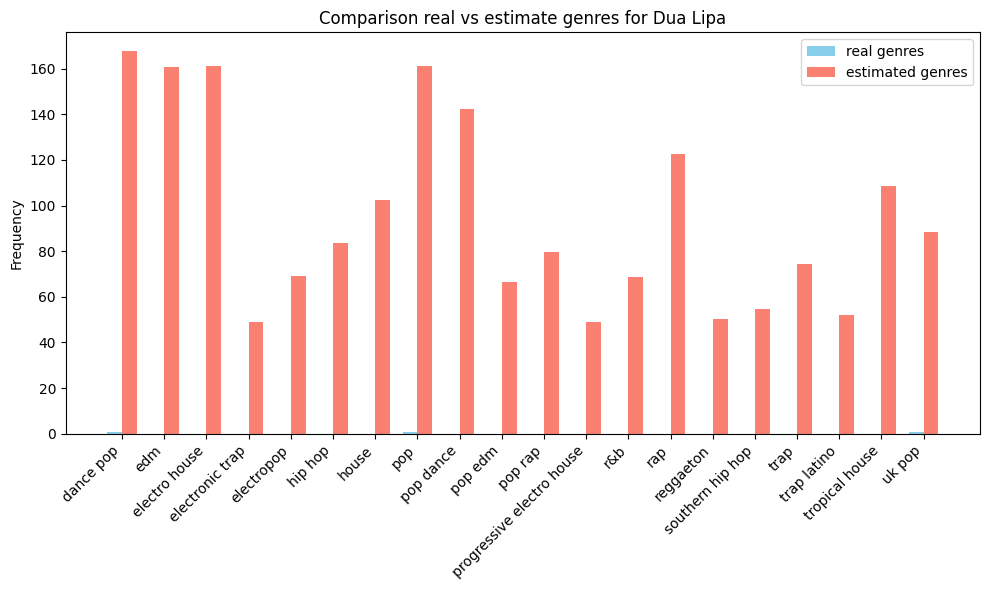

In [39]:
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, real_values, width, label='real genres', color='skyblue')
ax.bar(x + width/2, estimated_values, width, label='estimated genres', color='salmon')

ax.set_ylabel('Frequency')
ax.set_title(f'Comparison real vs estimate genres for {artist_name}')
ax.set_xticks(x)
ax.set_xticklabels(genres, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()


In [40]:
def get_neighbors_by_distance(G, node, max_depth=2):
    from collections import deque, defaultdict
    
    visited = set()
    distance_map = {}
    queue = deque([(node, 0)])
    
    while queue:
        current_node, depth = queue.popleft()
        if current_node in visited or depth > max_depth:
            continue
        visited.add(current_node)
        if depth > 0:
            distance_map.setdefault(depth, []).append(current_node)
        for neighbor in G.neighbors(current_node):
            if neighbor not in visited:
                queue.append((neighbor, depth + 1))
    return distance_map  # es. {1: [neighbor1], 2: [neighbor2]}


In [41]:
from collections import defaultdict

def estimate_genres_extended(G, node, weight_decay={1: 1.0, 2: 0.5}):
    neighbor_dict = get_neighbors_by_distance(G, node, max_depth=2)
    genre_weights = defaultdict(float)

    for dist, neighbors in neighbor_dict.items():
        weight = weight_decay.get(dist, 0.0)
        for neighbor in neighbors:
            genres = G.nodes[neighbor].get('genres', [])
            for genre in genres:
                genre_weights[genre] += weight
    return sorted(genre_weights.items(), key=lambda x: x[1], reverse=True)


In [42]:
estimated_genres = estimate_genres_extended(G, target_node)
for genre, weight in estimated_genres[:10]:
    print(f"{genre}: {weight:.2f}")


dance pop: 167.50
pop: 161.00
electro house: 161.00
edm: 160.50
pop dance: 142.50
rap: 122.50
tropical house: 108.50
house: 102.50
uk pop: 88.50
hip hop: 83.50


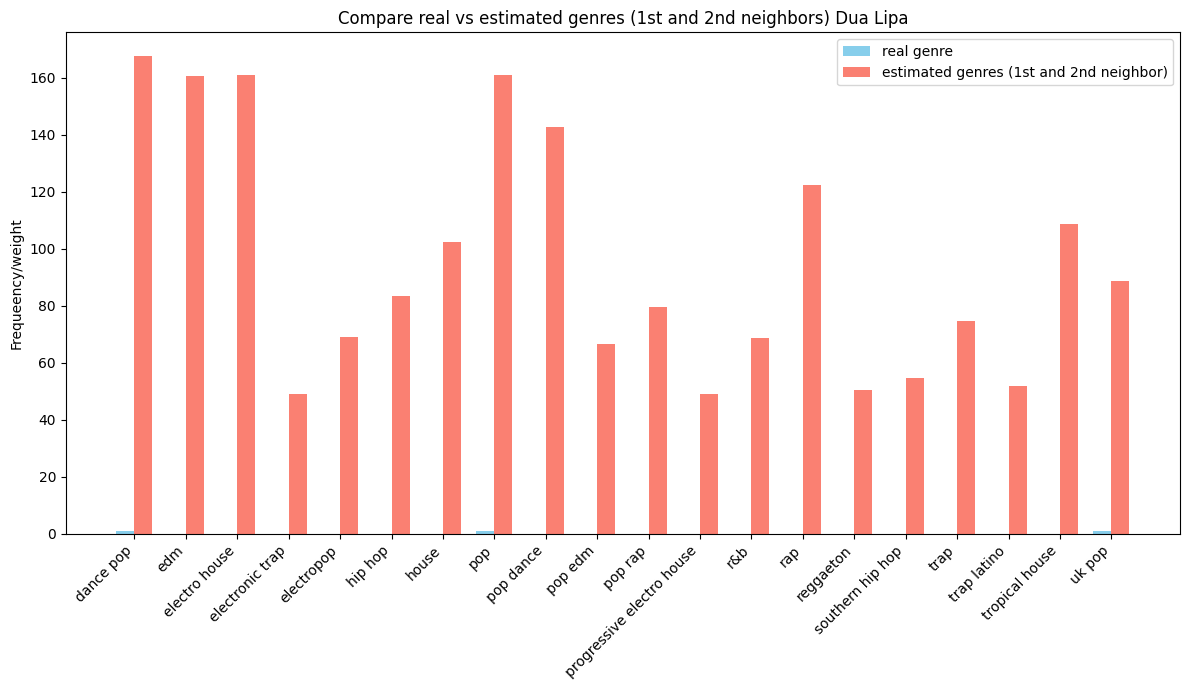

In [43]:
# now take real genres
real_genres = G.nodes[target_node].get('genres', [])
real_genre_counts = defaultdict(float)
for g in real_genres:
    real_genre_counts[g] += 1.0  

# extended estimate for real and estimated genres
estimated_genres = estimate_genres_extended(G, target_node)
estimated_genre_counts = dict(estimated_genres[:20])  # top 20 estimated

# sum genres to plot
all_genres = set(real_genre_counts.keys()).union(estimated_genre_counts.keys())
genres = sorted(all_genres)
x = np.arange(len(genres))

real_values = [real_genre_counts.get(g, 0) for g in genres]
estimated_values = [estimated_genre_counts.get(g, 0) for g in genres]


width = 0.35
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(x - width/2, real_values, width, label='real genre', color='skyblue')
ax.bar(x + width/2, estimated_values, width, label='estimated genres (1st and 2nd neighbor)', color='salmon')

ax.set_ylabel('Frequeency/weight')
ax.set_title(f'Compare real vs estimated genres (1st and 2nd neighbors) {artist_name}')
ax.set_xticks(x)
ax.set_xticklabels(genres, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

From the previous histograms we see what are the grenres of Dua Lipa's neighbors. But if we compare these with the real genres of Dua Lipa we found a discrepacy as expected, since for Dua Lipa we obviously have just one count for each genre. Thus the smallness of the lighblue bar is expected. To better compare we now focus on the common genres only and we see how the prevision change with first and second neighbors.

In [44]:
real_set = set(real_genres)
estimated_set = set([g for g, w in estimated_genres])
intersection = real_set.intersection(estimated_set)
union = real_set.union(estimated_set)
jaccard_similarity = len(intersection) / len(union) if union else 0
print(f"Jaccard similarity: {jaccard_similarity:.2f}")


Jaccard similarity: 0.00


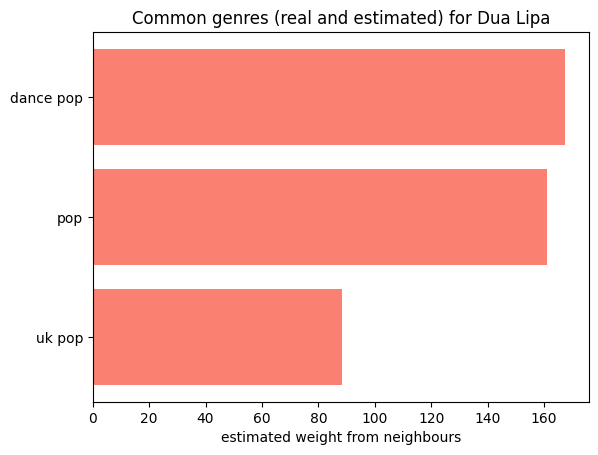

In [46]:
common_genres = real_set.intersection(estimated_set)
if common_genres:
    common_weights = {g: dict(estimated_genres).get(g, 0) for g in common_genres}

    genres = list(common_weights.keys())
    weights = list(common_weights.values())

    plt.barh(genres, weights, color='salmon')
    plt.xlabel('estimated weight from neighbours')
    plt.title(f"Common genres (real and estimated) for {artist_name}")
    plt.show()
else:
    print("No common genres")



In [47]:
# estimate first neighbors (weight 1)
estimated_first = estimate_genres_extended(G, target_node, weight_decay={1: 1.0})

# estimate first +second neighbor (weight 1 and 0.5)
estimated_first_second = estimate_genres_extended(G, target_node, weight_decay={1: 1.0, 2: 0.5})

estimated_first_dict = dict(estimated_first)
estimated_first_second_dict = dict(estimated_first_second)

common_first = real_set.intersection(set(estimated_first_dict.keys()))
common_first_second = real_set.intersection(set(estimated_first_second_dict.keys()))


In [48]:


all_common = sorted(common_first.union(common_first_second))
x = np.arange(len(all_common))
width = 0.35

weights_first = [estimated_first_dict.get(g, 0) for g in all_common]
weights_first_second = [estimated_first_second_dict.get(g, 0) for g in all_common]


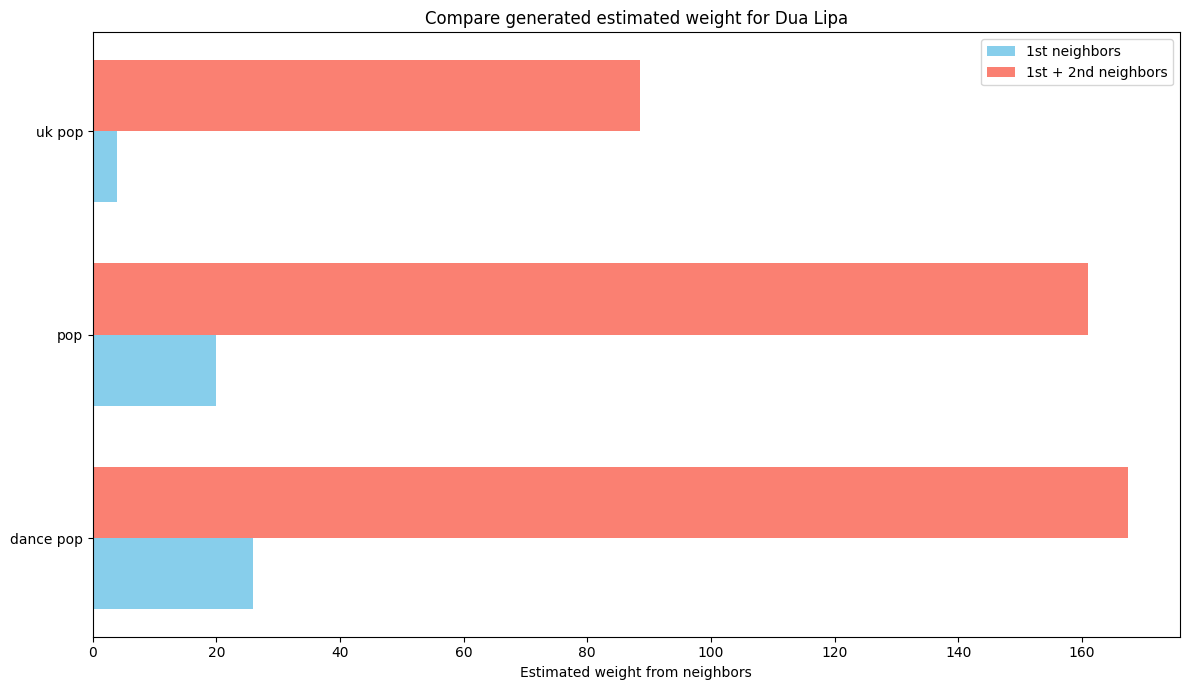

In [49]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.barh(x - width/2, weights_first, height=width, label='1st neighbors', color='skyblue')
ax.barh(x + width/2, weights_first_second, height=width, label='1st + 2nd neighbors', color='salmon')

ax.set_yticks(x)
ax.set_yticklabels(all_common)
ax.set_xlabel('Estimated weight from neighbors')

ax.set_title(f"Compare generated estimated weight for {artist_name}")
ax.legend()
plt.tight_layout()
plt.show()


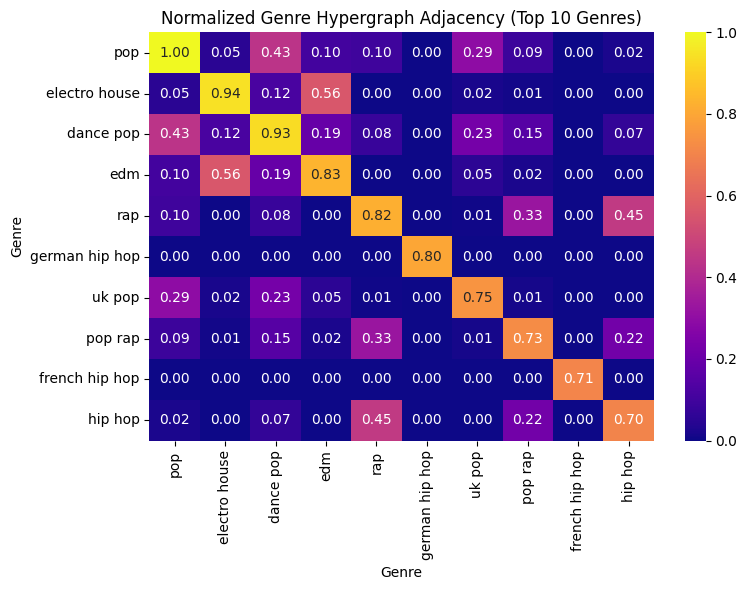

In [16]:
# Get top N genres
all_genres = [genre for genres in nodes_df['genres'] for genre in genres]
genre_counts = Counter(all_genres)
top_n = 10
top_genres = [g for g, _ in genre_counts.most_common(top_n)]

# Initialize co-occurrence matrix
co_matrix = pd.DataFrame(0, index=top_genres, columns=top_genres)

# Fill the matrix for off-diagonal (pairs)
#for eache artist and for every pair of thei genres, increment the count for that genre pair
for genres in nodes_df['genres']:
    genres_in_artist = [g for g in genres if g in top_genres]
    for g1, g2 in combinations(genres_in_artist, 2):#count pairs of different gerne per artist
        co_matrix.loc[g1, g2] += 1
        co_matrix.loc[g2, g1] += 1  # symmetric


# Fill the diagonal: number of artists in each genre
#the diagonal represents the number of artists that have that genre (size of the genre)
for genre in top_genres:
    co_matrix.loc[genre, genre] = sum(genre in genres for genres in nodes_df['genres'])

# Normalize by the maximum value in the matrix
co_matrix_norm = co_matrix / co_matrix.values.max()

# Plot normalized heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_matrix_norm, annot=True, fmt=".2f", cmap="plasma")
plt.title("Normalized Genre Hypergraph Adjacency (Top 10 Genres)")
plt.xlabel("Genre")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

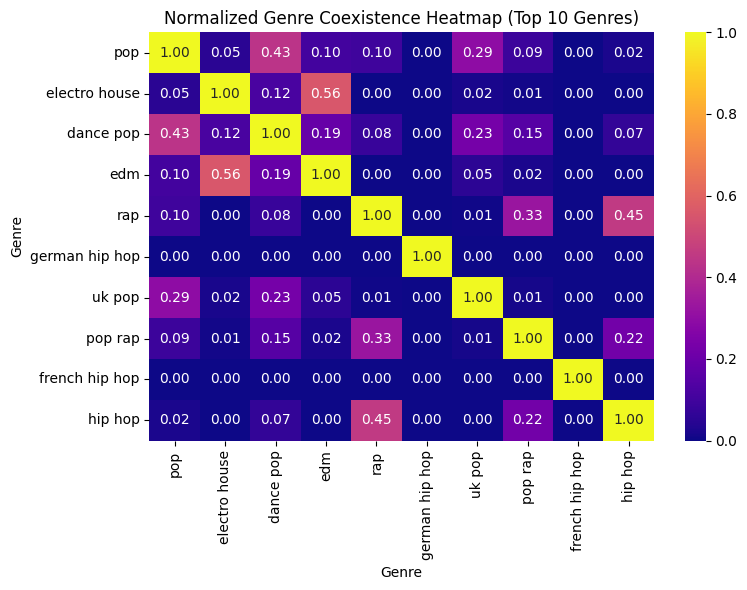

In [17]:
# Normalize the matrix (divide by max value)
co_matrix_norm = co_matrix / co_matrix.values.max()

# Set diagonal to 1.0
np.fill_diagonal(co_matrix_norm.values, 1.0)

# Plot normalized heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_matrix_norm, annot=True, fmt=".2f", cmap="plasma")
plt.title("Normalized Genre Coexistence Heatmap (Top 10 Genres)")
plt.xlabel("Genre")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

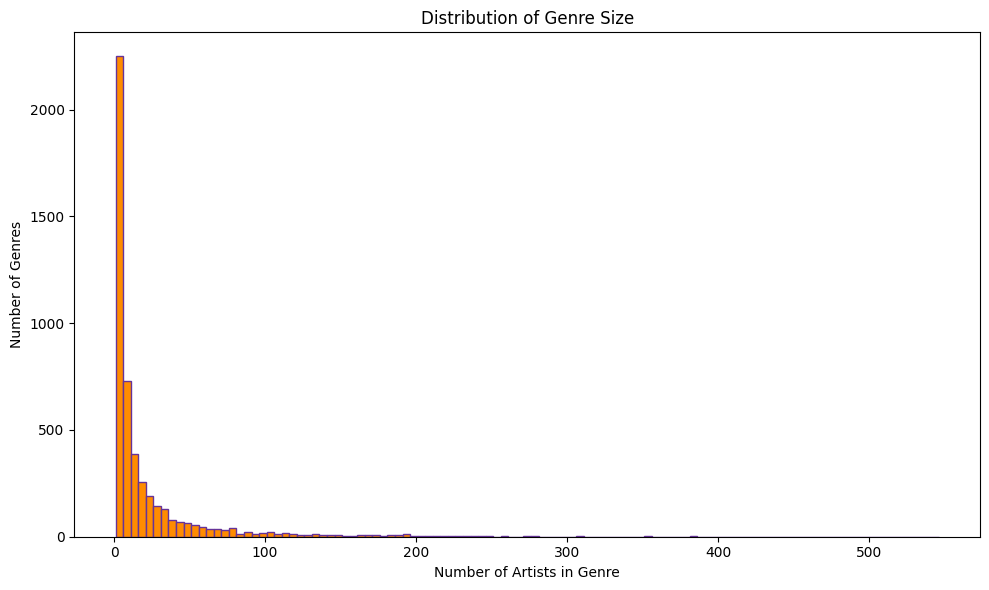

In [18]:
all_genres = [genre for genres in nodes_df['genres'] for genre in genres]
genre_counts = Counter(all_genres)

# take only the sizes (number of artists per genre)
genre_sizes = list(genre_counts.values())

# Hist: x = number of artists per genre, y = number of genres
plt.figure(figsize=(10, 6))
plt.hist(genre_sizes, bins=range(1, max(genre_sizes)+5, 5), color='darkorange', edgecolor='rebeccapurple')
plt.xlabel("Number of Artists in Genre")
plt.ylabel("Number of Genres")
plt.title("Distribution of Genre Size")
plt.tight_layout()
plt.show()

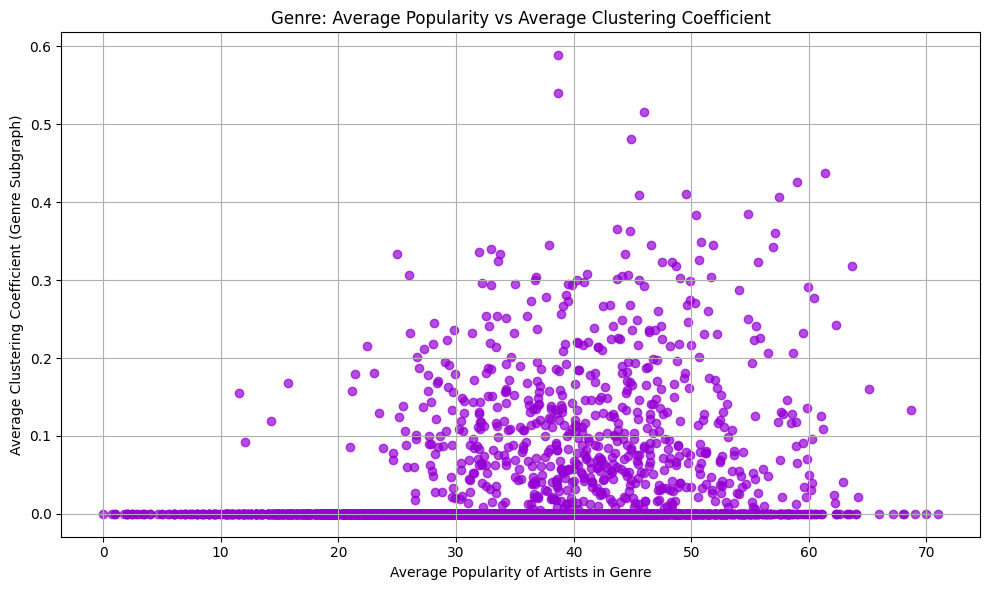

In [19]:
genre_to_clustering = {}
genre_to_popularity = {}

for genre in set(g for genres in nodes_df['genres'] for g in genres):
    # Get nodes with this genre
    genre_nodes = [n for n, d in G.nodes(data=True) if genre in d.get('genres', [])]
    if len(genre_nodes) < 2:
        continue  # skip genres with too few artists
    subG = G.subgraph(genre_nodes)
    # Average clustering coefficient for this genre's subgraph
    avg_clust = nx.average_clustering(subG)
    # Average popularity for this genre
    pops = [G.nodes[n].get('popularity', 0) for n in genre_nodes if G.nodes[n].get('popularity') is not None]
    if not pops:
        continue
    avg_pop = np.mean(pops)
    genre_to_clustering[genre] = avg_clust
    genre_to_popularity[genre] = avg_pop

plt.figure(figsize=(10,6))
plt.scatter(list(genre_to_popularity.values()), list(genre_to_clustering.values()), alpha=0.7, color='darkviolet')
plt.xlabel("Average Popularity of Artists in Genre")
plt.ylabel("Average Clustering Coefficient (Genre Subgraph)")
plt.title("Genre: Average Popularity vs Average Clustering Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

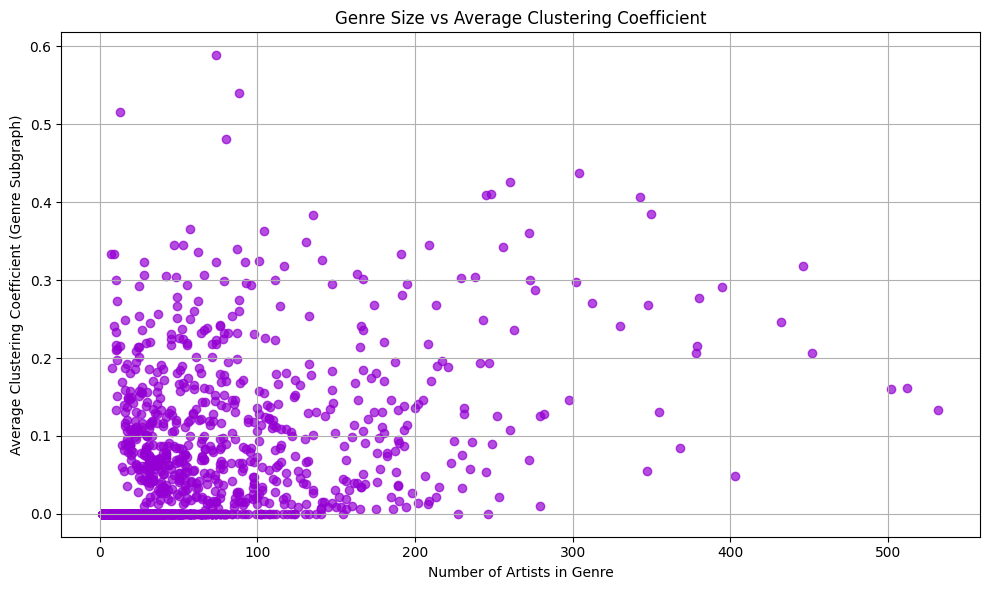

In [20]:
genre_sizes = []
genre_avg_clustering = []

for genre in genre_to_clustering:
    genre_sizes.append(len([n for n, d in G.nodes(data=True) if genre in d.get('genres', [])]))
    genre_avg_clustering.append(genre_to_clustering[genre])

plt.figure(figsize=(10,6))
plt.scatter(genre_sizes, genre_avg_clustering, alpha=0.7, color='darkviolet')
plt.xlabel("Number of Artists in Genre")
plt.ylabel("Average Clustering Coefficient (Genre Subgraph)")
plt.title("Genre Size vs Average Clustering Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
import ast
from ast import literal_eval
from community import community_louvain
import matplotlib.cm as cm
from networkx.algorithms.community import modularity
from collections import defaultdict


nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
nodes_df['chart_hits'] = nodes_df['chart_hits'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])


# filter out nodes w/ empty 'chart_hits':
chart_topping_nodes = nodes_df[nodes_df['chart_hits'].apply(lambda x: len(x) > 0)]['spotify_id'].tolist()

print(f"\nNumber of chart-topping nodes: {len(chart_topping_nodes)}")

G = nx.Graph()

# add nodes:
for _, row in nodes_df.iterrows():
    G.add_node(row['spotify_id'], **row.to_dict())

# add edges:
for _, row in edges_df.iterrows():
    G.add_edge(row['id_0'], row['id_1'])

# create subgraph of chart-topping artists:
subgraph = G.subgraph(chart_topping_nodes).copy()

# count:
subgraph_node_count = subgraph.number_of_nodes()
subgraph_edge_count = subgraph.number_of_edges()

print(f"Node count: {subgraph_node_count}")
print(f"Edge count: {subgraph_edge_count}")

# Louvain method for community detection:
if subgraph_node_count > 0:
    partition = community_louvain.best_partition(subgraph)
    num_communities = len(set(partition.values()))
    print(f"\nNumber of communities detected: {num_communities}")

    # group nodes by community:
    community_groups = defaultdict(list)
    for node, community_id in partition.items():
        community_groups[community_id].append(node)

    # display sample community groups:
    print("\nSample community group:")
    sample_communities = dict(list(community_groups.items())[:1])
    print(sample_communities)


Number of chart-topping nodes: 19641
Node count: 19562
Edge count: 72207

Number of communities detected: 5918

Sample community group:
{0: ['6p0HFtE6QhdHNY1H4Nk0mo']}


In [22]:
from community import community_louvain
from networkx.algorithms.community import modularity

# convert partition dict into list of sets (format required by networkx's modularity function):
communities = defaultdict(set)
for node, community_id in partition.items():
    communities[community_id].add(node)

# convert dict values to list of sets:
community_list = list(communities.values())

# compute modularity score:
modularity_score = modularity(subgraph, community_list)

print(f"\nModularity Score: {modularity_score:.4f}")


Modularity Score: 0.7444


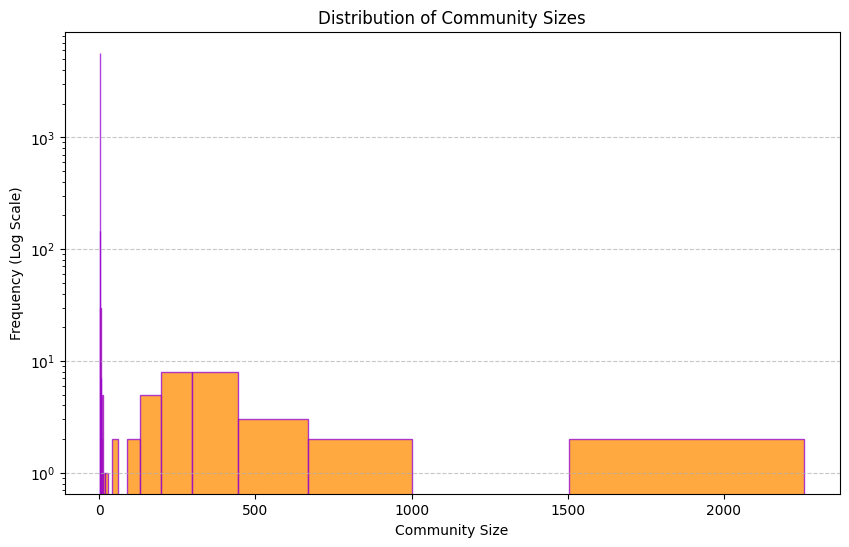

In [23]:
# histogram of community sizes:
community_sizes = [len(nodes) for nodes in community_groups.values()]
plt.figure(figsize=(10, 6))

# adjust bins dynamically based on data range:
bins = np.logspace(np.log10(min(community_sizes)), np.log10(max(community_sizes)), num=20)

plt.hist(community_sizes, bins=bins, edgecolor='darkviolet', color='darkorange', alpha=0.75)
plt.yscale('log')  # log scale to better spread values
plt.xlabel('Community Size')
plt.ylabel('Frequency (Log Scale)')
plt.title('Distribution of Community Sizes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

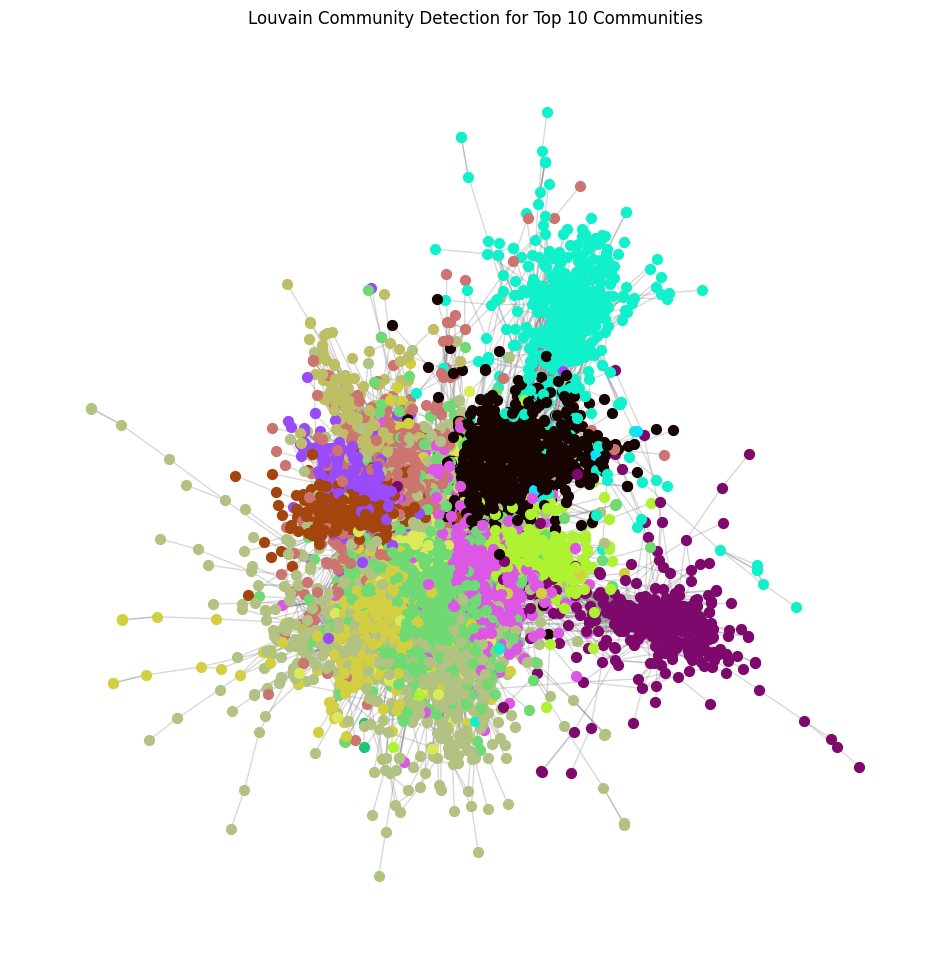

In [24]:
import random
# choose top 10 communities based on size:
top_10_communities = sorted(community_groups.items(), key=lambda x: len(x[1]), reverse=True)[:10]

# create graph w/ only nodes from top 10 communities:
top_10_nodes = [node for community_id, members in top_10_communities for node in members]
top_10_subgraph = G.subgraph(top_10_nodes).copy()

# apply Louvain partitioning on top 10 subgraph:
top_10_partition = community_louvain.best_partition(top_10_subgraph)

# generate colors for each community:
unique_communities = list(set(top_10_partition.values()))
community_colors = {community_id: (random.random(), random.random(), random.random()) for community_id in unique_communities}

# positioning:
pos = nx.spring_layout(top_10_subgraph, seed=42)

# plot graph w/ communities colored:
plt.figure(figsize=(12, 12))
for node, community_id in top_10_partition.items():
    nx.draw_networkx_nodes(top_10_subgraph, pos, nodelist=[node], node_size=50, node_color=[community_colors[community_id]])

nx.draw_networkx_edges(top_10_subgraph, pos, alpha=0.3, edge_color="gray")
plt.title("Louvain Community Detection for Top 10 Communities")
plt.axis("off")
plt.show()

Statistics for each community:
number of nodes, density of the subgraph, mean degree and distribution of genres, country and popularity

In [25]:
# Find the top 10 communities by number of nodes
top_10_communities = sorted(community_groups.items(), key=lambda x: len(x[1]), reverse=True)[:10]

for community_id, nodes in top_10_communities:
    sub = subgraph.subgraph(nodes)
    size = sub.number_of_nodes()
    density = nx.density(sub)
    avg_degree = sum(dict(sub.degree()).values()) / size if size > 0 else 0

    # Distribuzione dei generi
    genres = []
    for n in nodes:
        genres.extend(sub.nodes[n]['genres'])
    genre_counts = pd.Series(genres).value_counts().head(5)

    print(f"\nCommunity {community_id}:")
    print(f"Size: {size}")
    print(f"Density: {density:.4f}")
    print(f"Average degree: {avg_degree:.2f}")
    print(f"Top genres: {genre_counts.to_dict()}")




Community 1:
Size: 2259
Density: 0.0056
Average degree: 12.65
Top genres: {}

Community 24:
Size: 1788
Density: 0.0082
Average degree: 14.73
Top genres: {}

Community 2:
Size: 982
Density: 0.0056
Average degree: 5.47
Top genres: {}

Community 12:
Size: 677
Density: 0.0123
Average degree: 8.33
Top genres: {}

Community 7:
Size: 655
Density: 0.0199
Average degree: 12.99
Top genres: {}

Community 15:
Size: 589
Density: 0.0183
Average degree: 10.75
Top genres: {}

Community 36:
Size: 452
Density: 0.0086
Average degree: 3.88
Top genres: {}

Community 28:
Size: 438
Density: 0.0143
Average degree: 6.25
Top genres: {}

Community 16:
Size: 413
Density: 0.0369
Average degree: 15.20
Top genres: {}

Community 5:
Size: 400
Density: 0.0280
Average degree: 11.19
Top genres: {}


In [26]:
centrality_summary = []

for community_id, nodes in top_10_communities:
    sub = subgraph.subgraph(nodes)
    
    # neglect too small communities
    if sub.number_of_nodes() < 2:
        continue
    
    deg_cent = nx.degree_centrality(sub)
    betw_cent = nx.betweenness_centrality(sub)
    clos_cent = nx.closeness_centrality(sub)
    
    
    for node in sub.nodes:
        centrality_summary.append({
            'community_id': community_id,
            'node_id': node,
            'name': sub.nodes[node].get('name', ''),
            'degree_centrality': deg_cent.get(node, 0),
            'betweenness_centrality': betw_cent.get(node, 0),
            'closeness_centrality': clos_cent.get(node, 0)
        })


cent_df = pd.DataFrame(centrality_summary)

# show top 3 nodes by degree centrality in each top 10 community
for comm in cent_df['community_id'].unique():
    print(f"\nCommunity {comm}")
    top_nodes = cent_df[cent_df['community_id'] == comm].sort_values('degree_centrality', ascending=False).head(3)
    for _, row in top_nodes.iterrows():
        print(f"  {row['name']} | Degree: {row['degree_centrality']:.3f}, Betweenness: {row['betweenness_centrality']:.3f}, Closeness: {row['closeness_centrality']:.3f}")

# compare communities
grouped = cent_df.groupby('community_id').agg({
    'degree_centrality': ['mean', 'max'],
    'betweenness_centrality': ['mean', 'max'],
    'closeness_centrality': ['mean', 'max']
}).reset_index()


grouped.columns = ['community_id',
                   'degree_mean', 'degree_max',
                   'betweenness_mean', 'betweenness_max',
                   'closeness_mean', 'closeness_max']

print("\nSummary by community:")
print(grouped.sort_values('degree_mean', ascending=False))



Community 1
  Farruko | Degree: 0.078, Betweenness: 0.060, Closeness: 0.395
  De La Ghetto | Degree: 0.062, Betweenness: 0.021, Closeness: 0.370
  R3HAB | Degree: 0.058, Betweenness: 0.083, Closeness: 0.379

Community 24
  Ty Dolla $ign | Degree: 0.105, Betweenness: 0.039, Closeness: 0.429
  Lil Wayne | Degree: 0.082, Betweenness: 0.016, Closeness: 0.410
  French Montana | Degree: 0.080, Betweenness: 0.024, Closeness: 0.416

Community 2
  Petter | Degree: 0.052, Betweenness: 0.123, Closeness: 0.308
  Cherrie | Degree: 0.035, Betweenness: 0.033, Closeness: 0.299
  Jireel | Degree: 0.035, Betweenness: 0.030, Closeness: 0.296

Community 12
  Olexesh | Degree: 0.105, Betweenness: 0.097, Closeness: 0.378
  Sido | Degree: 0.099, Betweenness: 0.135, Closeness: 0.394
  Capital Bra | Degree: 0.098, Betweenness: 0.056, Closeness: 0.379

Community 7
  Mc Gw | Degree: 0.125, Betweenness: 0.033, Closeness: 0.370
  DENNIS | Degree: 0.121, Betweenness: 0.058, Closeness: 0.411
  Mc Don Juan | Degree:

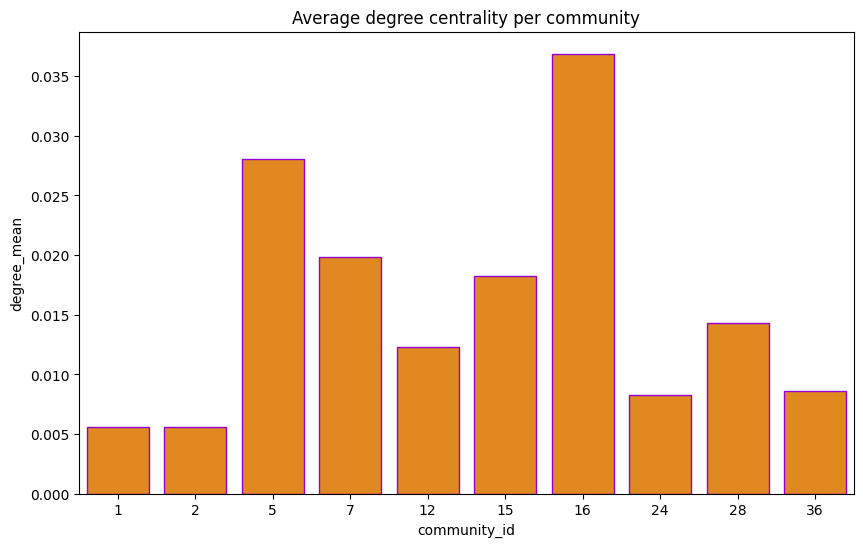

In [27]:

plt.figure(figsize=(10,6))
sns.barplot(data=grouped.sort_values('degree_mean', ascending=False),
            x='community_id', y='degree_mean', color='darkorange', edgecolor='darkviolet')
plt.title('Average degree centrality per community')
plt.show()


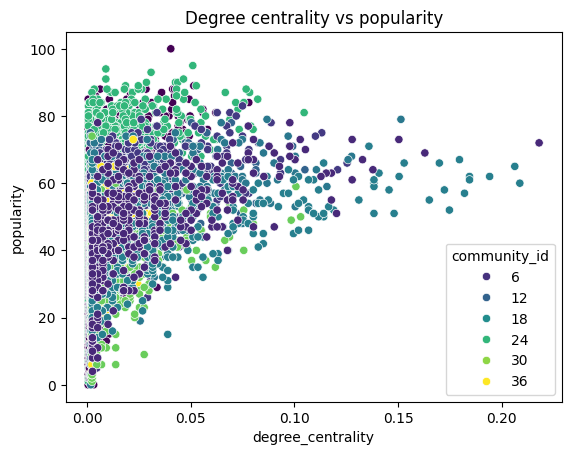

In [28]:
# see if degree centrality correlates with popularity
cent_df = cent_df.merge(nodes_df[['spotify_id', 'popularity']], left_on='node_id', right_on='spotify_id', how='left')
sns.scatterplot(data=cent_df, x='degree_centrality', y='popularity', hue='community_id', palette='viridis')
plt.title('Degree centrality vs popularity')
plt.show()


In [35]:
def estimate_genres_by_neighbors(G, node, top_n=5):
    """
    Estimate an artist genre according to his neighbours genres
    gives top_n genres more frequent among neighbors, weighted with frequency
    """
    if node not in G:
        return []
    neighbor_genres = []
    for neighbor in G.neighbors(node):
        genres = G.nodes[neighbor].get('genres', [])
        neighbor_genres.extend(genres)
    if not neighbor_genres:
        return []
    genre_counts = Counter(neighbor_genres)
    # Restituisce una lista di tuple (genere, conteggio)
    return genre_counts.most_common(top_n)

#search an artist with neighbors and genres
found = False
for node in G.nodes():
    vicini = list(G.neighbors(node))
    neighbor_genres = []
    for v in vicini:
        neighbor_genres.extend(G.nodes[v].get('genres', []))
    if neighbor_genres:
        print(f"Artista: {G.nodes[node].get('name', node)}")
        print("Stima generi:", estimate_genres_by_neighbors(G, node, top_n=5))
        found = True
if not found:
    print("Nessun artista con vicini che hanno generi trovati.")



Nessun artista con vicini che hanno generi trovati.
